# Inverse Probability Weighting (IPW)

### Case Study
- Chesnaye, N. C., Stel, V. S., Tripepi, G., Dekker, F. W., Fu, E. L., Zoccali, C., & Jager, K. J. (2021). An introduction to inverse probability of treatment weighting in observational research. *Clinical Kidney Journal, 15*(1), 14–20. <https://doi.org/10.1093/ckj/sfab158>

### Synthetic Data

In [83]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Try import dowhy
try:
    from dowhy import CausalModel
except Exception:
    raise ImportError("Install DoWhy first: pip install dowhy")

# -----------------------------
# Step 1: Generate synthetic dataset
# -----------------------------
np.random.seed(42)
n = 5000

# Baseline covariates
age = np.random.normal(65, 12, n)
sex = np.random.binomial(1, 0.5, n)  # 1=male, 0=female
dialysis_vintage = np.random.exponential(4, n)
previous_transplant = np.random.binomial(1, 0.2, n)
diabetes = np.random.binomial(1, 0.3, n)
ischemic_hd = np.random.binomial(1, 0.25, n)
cerebrovascular = np.random.binomial(1, 0.15, n)
peripheral_vascular = np.random.binomial(1, 0.10, n)
malignancy = np.random.binomial(1, 0.08, n)

# Combine into DataFrame
data = pd.DataFrame({
    'age': age,
    'sex': sex,
    'dialysis_vintage': dialysis_vintage,
    'previous_transplant': previous_transplant,
    'diabetes': diabetes,
    'ischemic_hd': ischemic_hd,
    'cerebrovascular': cerebrovascular,
    'peripheral_vascular': peripheral_vascular,
    'malignancy': malignancy
})

# -----------------------------
# Step 2: Simulate treatment assignment (EHD vs CHD)
# -----------------------------
logit_scores = (
    -3 + 0.02*age - 0.5*diabetes - 0.3*ischemic_hd - 0.2*cerebrovascular + 0.1*previous_transplant
)
ps = 1 / (1 + np.exp(-logit_scores))
treatment = np.random.binomial(1, ps)
data['treatment'] = treatment  # 1=EHD, 0=CHD

# -----------------------------
# Step 3: Simulate outcome (event occurrence)
# -----------------------------
# Probability influenced by treatment and comorbidities
logit_outcome = -2 + (-0.5*treatment) + (0.4*diabetes) + (0.3*ischemic_hd)
prob_event = 1 / (1 + np.exp(-logit_outcome))
event = np.random.binomial(1, prob_event)
data['event'] = event
data.describe()

,age,sex,dialysis_vintage,previous_transplant,diabetes,ischemic_hd,cerebrovascular,peripheral_vascular,malignancy,treatment,event
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,65.067223,0.490800,4.048000,0.202000,0.303200,0.241200,0.151400,0.104600,0.07860,0.129000,0.137000
std,11.957758,0.499965,4.135830,0.401532,0.459687,0.427854,0.358474,0.306068,0.26914,0.335233,0.343882
min,26.104792,0.000000,0.000631,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,57.105140,0.000000,1.115499,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,65.161587,0.000000,2.717719,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,72.992127,1.000000,5.695923,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,112.114852,1.000000,37.982865,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


### DAG

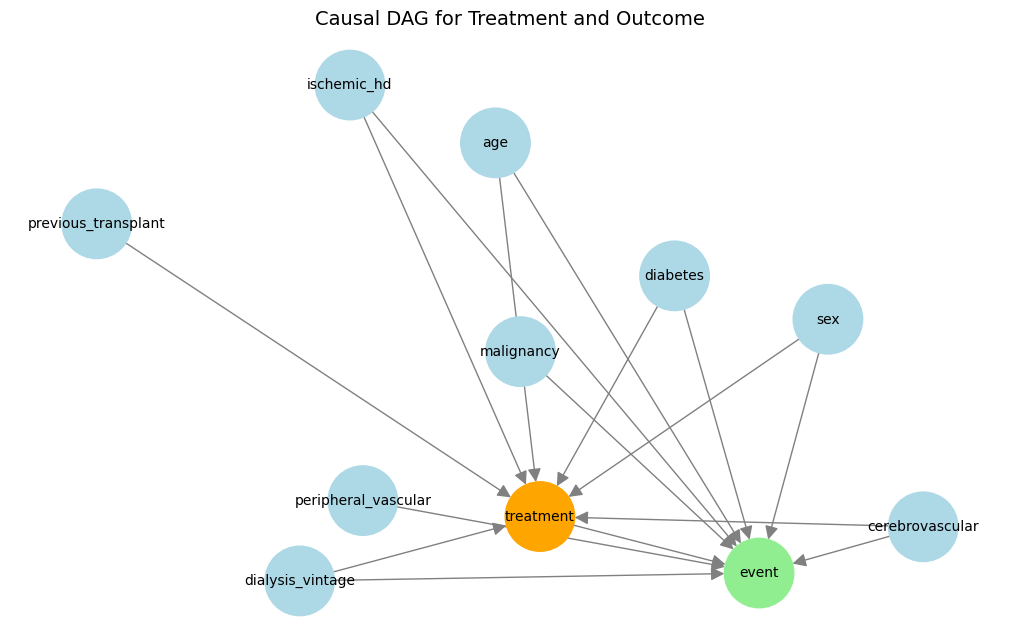

In [91]:
import matplotlib.pyplot as plt
import networkx as nx

# Define nodes and edges for your DAG
nodes = [
    "age", "sex", "dialysis_vintage", "previous_transplant",
    "diabetes", "ischemic_hd", "cerebrovascular",
    "peripheral_vascular", "malignancy", "treatment", "event"
]

edges = [
    ("age", "treatment"), ("age", "event"),
    ("sex", "treatment"), ("sex", "event"),
    ("dialysis_vintage", "treatment"), ("dialysis_vintage", "event"),
    ("previous_transplant", "treatment"),
    ("diabetes", "treatment"), ("diabetes", "event"),
    ("ischemic_hd", "treatment"), ("ischemic_hd", "event"),
    ("cerebrovascular", "treatment"), ("cerebrovascular", "event"),
    ("peripheral_vascular", "event"),
    ("malignancy", "event"),
    ("treatment", "event")
]

# Create DAG
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Define node colors (same scheme as your example)
node_colors = {
    "age": "lightblue",
    "sex": "lightblue",
    "dialysis_vintage": "lightblue",
    "previous_transplant": "lightblue",
    "diabetes": "lightblue",
    "ischemic_hd": "lightblue",
    "cerebrovascular": "lightblue",
    "peripheral_vascular": "lightblue",
    "malignancy": "lightblue",
    "treatment": "orange",
    "event": "lightgreen"
}

# Draw DAG
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(10, 6))
nx.draw(
    G, pos, with_labels=True,
    node_color=[node_colors[node] for node in G.nodes()],
    node_size=2500, arrowsize=20, edge_color='gray', font_size=10
)
plt.title("Causal DAG for Treatment and Outcome", fontsize=14)
plt.show()

### DoWhy

In [84]:
# DoWhy causal model with CI
model = CausalModel(
    data=data,
    treatment="treatment",
    outcome="event",
    common_causes=covariates,
    confidence_intervals=True
)

identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

# Estimate ATE with bootstrap confidence intervals
ate_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_weighting",
    confidence_intervals=True,       # Enable CI
)

# Estimate ATT with bootstrap confidence intervals
att_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_weighting",
    target_units="att",
    confidence_intervals=True
)

print("\nATE (IPW, DoWhy):", round(ate_estimate.value,3))
print("ATE 95% CI:", ate_estimate.get_confidence_intervals())

print("\nATT (IPW, DoWhy):", round(att_estimate.value,3))
print("ATT 95% CI:", att_estimate.get_confidence_intervals())


ATE (IPW, DoWhy): -0.059
ATE 95% CI: (-0.08378476230912266, -0.03367870126272027)

ATT (IPW, DoWhy): -0.057
ATT 95% CI: (-0.08042245513976254, -0.031484650905763814)


In [85]:
# CATE by age tertile
data["age_tertile"] = pd.qcut(data["age"], q=3, labels=["young","mid","old"])
cate_results = {}
for grp, subset in data.groupby("age_tertile"):
    treated_grp = subset[subset.treatment==1]["event"]
    control_grp = subset[subset.treatment==0]["event"]
    if len(treated_grp) > 5 and len(control_grp) > 5:
        cate_results[grp] = treated_grp.mean() - control_grp.mean()

print("\nCATE by age tertile:")
for grp, val in cate_results.items():
    print(f"  {grp}: {val:.3f}")


CATE by age tertile:
  young: -0.099
  mid: -0.043
  old: -0.061


In [86]:
# Compute propensity scores & IPW
covariates = ["age","sex","dialysis_vintage","previous_transplant","diabetes",
              "ischemic_hd","cerebrovascular","peripheral_vascular","malignancy"]
X = data[covariates]
y = data["treatment"]

logit = LogisticRegression(max_iter=n)
logit.fit(X, y)
data["pscore"] = logit.predict_proba(X)[:,1]
data["ipw"] = np.where(data["treatment"]==1, 1/data["pscore"], 1/(1-data["pscore"]))

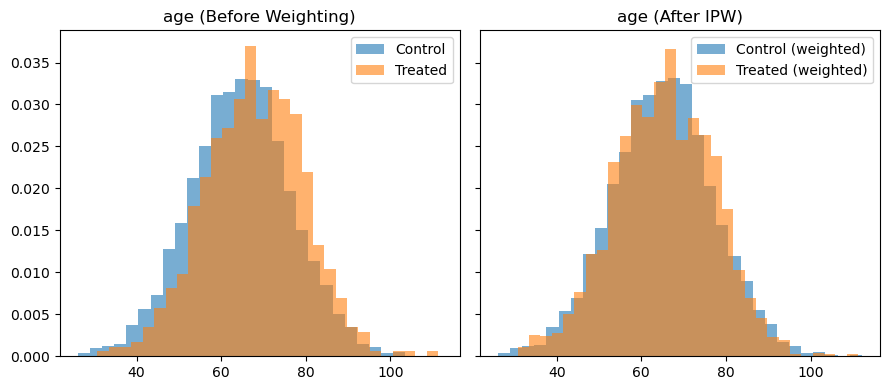

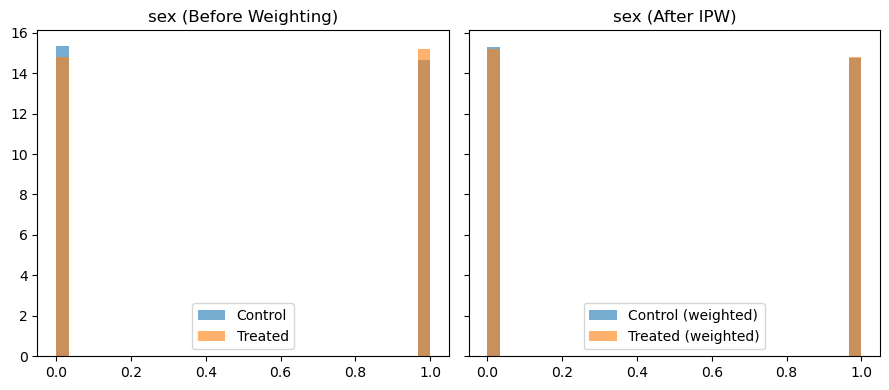

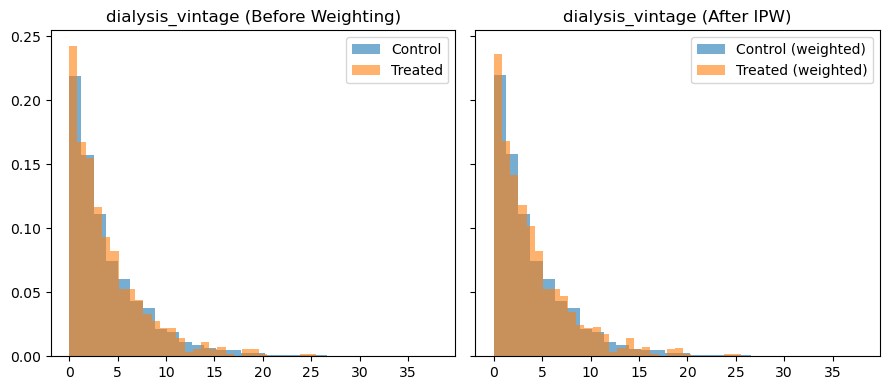

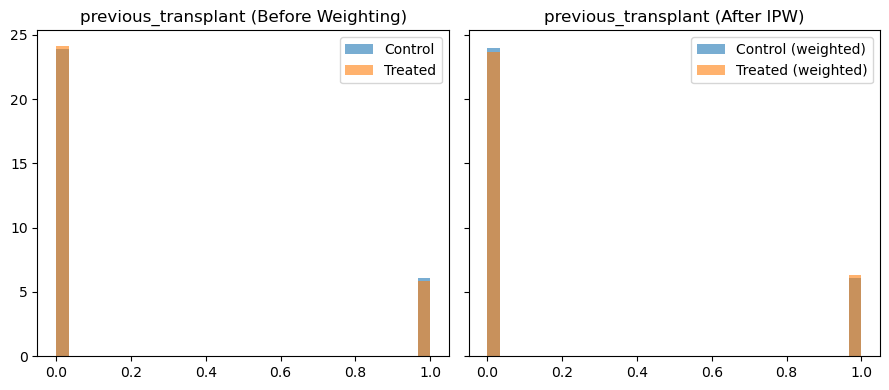

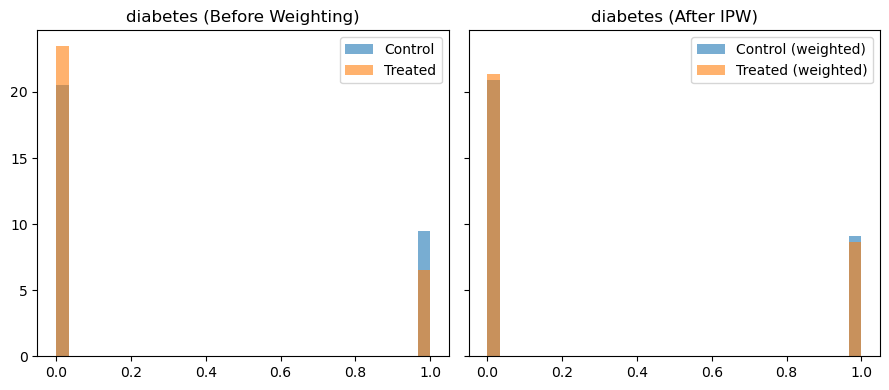

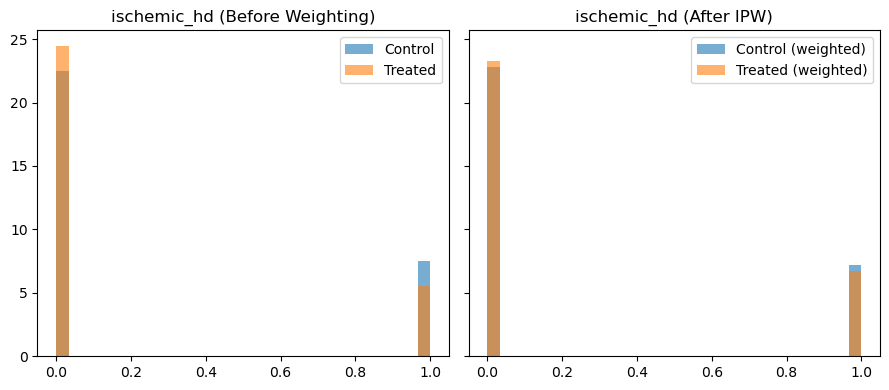

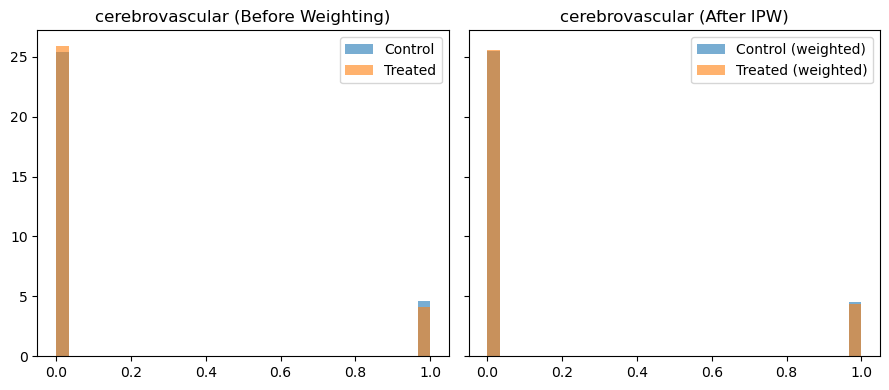

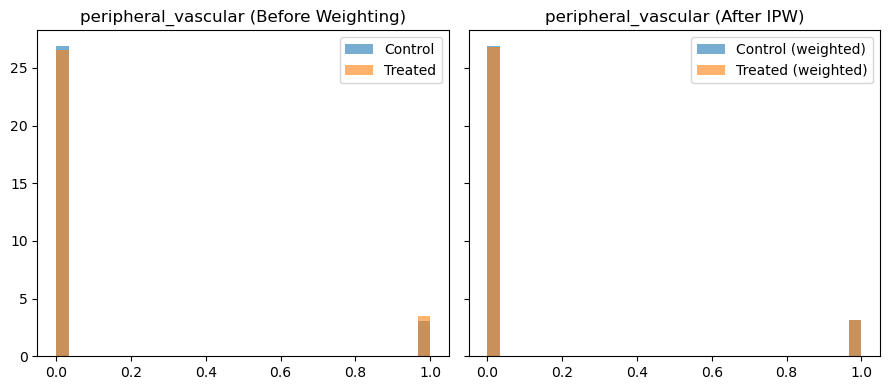

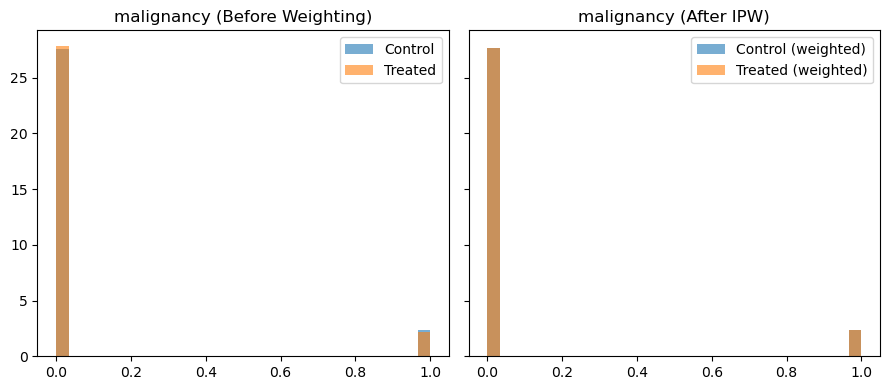

In [87]:
import matplotlib.pyplot as plt

def plot_balance_for_covariates(df, covariates, treatment_col="treatment", weight_col="ipw", bins=30):
    treated = df[df[treatment_col] == 1]
    control = df[df[treatment_col] == 0]
    
    for cov in covariates:
        fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
        
        # Before weighting
        axes[0].hist(control[cov], bins=bins, alpha=0.6, label="Control", density=True)
        axes[0].hist(treated[cov], bins=bins, alpha=0.6, label="Treated", density=True)
        axes[0].set_title(f"{cov} (Before Weighting)")
        axes[0].legend()
        
        # After weighting
        axes[1].hist(control[cov], bins=bins, weights=control[weight_col], alpha=0.6, label="Control (weighted)", density=True)
        axes[1].hist(treated[cov], bins=bins, weights=treated[weight_col], alpha=0.6, label="Treated (weighted)", density=True)
        axes[1].set_title(f"{cov} (After IPW)")
        axes[1].legend()
        
        plt.tight_layout()
        plt.show()

covariates = ["age","sex","dialysis_vintage","previous_transplant","diabetes",
              "ischemic_hd","cerebrovascular","peripheral_vascular","malignancy"]

plot_balance_for_covariates(data, covariates)

### Manual

In [80]:
# Estimate propensity scores
X = data[['age','sex','dialysis_vintage','previous_transplant','diabetes','ischemic_hd','cerebrovascular','peripheral_vascular','malignancy']]
ps_model = LogisticRegression(max_iter=n)
ps_model.fit(X, treatment)
propensity_scores = ps_model.predict_proba(X)[:,1]
data['ps'] = propensity_scores

# Compute and stablize the weights so they don’t become excessively large.
# p_treated = proportion of treated individuals in the sample.
p_treated = treatment.mean() # treatment is a binary variable (1 = treated, 0 = control)
weights = np.where(treatment==1, p_treated/propensity_scores, (1-p_treated)/(1-propensity_scores))
data['ipw'] = weights

# Apply weights to make a weighted pseudo-population
X_outcome = sm.add_constant(data[['treatment']])
model = sm.GLM(data['event'], X_outcome, family=sm.families.Binomial(), freq_weights=data['ipw'])
result = model.fit()

print("\nWeighted Logistic Regression Summary:\n", result.summary())


Weighted Logistic Regression Summary:
                  Generalized Linear Model Regression Results                  
Dep. Variable:                  event   No. Observations:                 5000
Model:                            GLM   Df Residuals:                  4991.85
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1984.1
Date:                Fri, 14 Nov 2025   Deviance:                       3968.2
Time:                        15:30:44   Pearson chi2:                 4.99e+03
No. Iterations:                     5   Pseudo R-squ. (CS):           0.003634
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       